# Fraud Email Detection
This project discusses the use of Fraud email detection.

In [12]:
#Importing relevant frameworks and classes
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss

In [13]:
#Lets start with configuring environment
RANDOM_SEED = 42
MAX_LEN = 256
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 3e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
#Importing datasets
df = pd.read_csv('emails.csv')
df = df.drop_duplicates().sample(frac=1).reset_index(drop=True)

In [15]:
#Splitting datasets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['email_text'], df['labels'],
    test_size = 0.2,
    random_state = RANDOM_SEED,
    stratify = df['labels'] #stratification
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size = 0.5,
    random_state = RANDOM_SEED
)
class_weights = compute_class_weight(
    'balanced',
    classes = np.unique(train_labels),
    y = train_labels
)
class_weights = torch.tensor(class_weights, dtype = torh.float).to(DEVICE)

NameError: name 'torh' is not defined

In [16]:
# collate function
def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'label': torch.tensor([item['label'] for item in batch])
    }
#Initializing BERT Tokenizer
tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased')
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [17]:
#Creating Dataloaders
train_dataset = EmailDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = EmailDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = EmailDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

In [19]:
#Model Initialization
class_counts = df['labels'].value_counts().to_list()
class_weights = 1 / torch.tensor(class_counts, dtype = torch.float)
class_weights = class_weights.to(DEVICE)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)
model = model.to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
#Optimizers and Schedulers
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.01)
total_steps = len(train_loader) * EPOCHS
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = total_steps)

In [21]:
#Early Stopping
best_val_loss = float('inf')
patience = 3
patience_counter = 0

In [22]:
#Training loop with validation
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(
            input_ids,
            attention_mask = attention_mask,
            labels = labels
        )
        loss_fct = CrossEntropyLoss(weight = class_weights)
        loss = loss_fct(outputs.logits, labels)
        epoch_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(
                input_ids,
                attention_mask = attention_mask,
                labels = labels
            )
            loss = outputs.loss
            epoch_val_loss += loss.item()
            _, preds = torch.max(outputs.logits, dim = 1)
            correct_predictions += torch.sum(preds == labels)
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = correct_predictions.double() / len(val_dataset)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Train Loss: {avg_train_loss: .4f} | Val loss: {avg_val_loss: .4f}')

    #Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.bin')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggerd")
            break

Epoch 1/10
Train Loss:  0.6875 | Val loss:  0.6205
Epoch 2/10
Train Loss:  0.6285 | Val loss:  0.5969
Epoch 3/10
Train Loss:  0.5450 | Val loss:  0.5268
Epoch 4/10
Train Loss:  0.4521 | Val loss:  0.4691
Epoch 5/10
Train Loss:  0.3854 | Val loss:  0.4509
Epoch 6/10
Train Loss:  0.2988 | Val loss:  0.4462
Epoch 7/10
Train Loss:  0.2574 | Val loss:  0.4340
Epoch 8/10
Train Loss:  0.2570 | Val loss:  0.4182
Epoch 9/10
Train Loss:  0.2253 | Val loss:  0.4086
Epoch 10/10
Train Loss:  0.2161 | Val loss:  0.4064


In [23]:
#Evaluatng Test set
model.load_state_dict(torch.load('best_model.bin'))
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        outputs = model(
            input_ids,
            attention_mask = attention_mask
        )

        _, preds = torch.max(outputs.logits, dim = 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average = 'weighted')

Test Results
Accuracy:  0.5000
F1 Score: 0.0000
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Confusion Matrix:
[[1 0]
 [1 0]]


C:\Users\ihpc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ihpc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ihpc\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

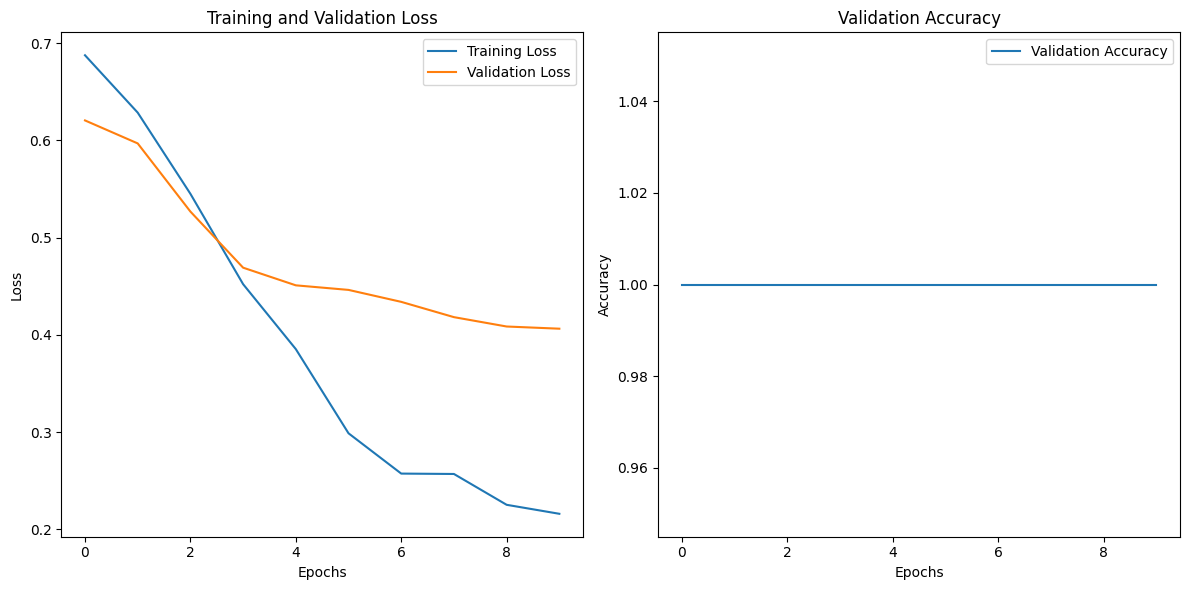

In [24]:
#Printing results
print("Test Results")
print(f"Accuracy: {accuracy_score(test_labels, test_preds): .4f}")
print(f"F1 Score: {f1_score(test_labels, test_preds):.4f}")
print(classification_report(test_labels, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))

#Visualization
plt.figure(figsize = (12,6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label = 'Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()